In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='Spectral')

In [2]:
df = pd.read_csv("archive/ratings_small.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
df.shape

(100004, 4)

In [4]:
os.listdir('archive/')

['credits.csv',
 'keywords.csv',
 'links.csv',
 'links_small.csv',
 'movies_metadata.csv',
 'ratings.csv',
 'ratings_small.csv']

In [5]:
df = df.drop(columns=['timestamp'])
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [6]:
print("Number of unique users", df.userId.nunique(), "\nNumber of unique movies", df.movieId.nunique())

Number of unique users 671 
Number of unique movies 9066


In [7]:
user_movie = df.pivot_table(index=['userId'], columns=['movieId'], values=['rating'])
# user_movie = user_movie.fillna(0)
user_movie.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
5          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 161084 161155 161594 161830 161918 161944 162376 162542 162672   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 163949  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  

[5 rows x 9066 columns]

In [17]:
user_movie.loc[555][~np.isnan(user_movie.loc[55]) & ~np.isnan(user_movie.loc[555])]

        movieId
rating  95         1.0
        260        5.0
        608        4.0
        648        3.0
        719        1.0
        780        3.0
        786        3.0
        802        1.0
Name: 555, dtype: float64

In [18]:
def user_cosine_similarity(vec1, vec2):
    # check common ratings between two users
    both_rated = ~np.isnan(vec1) & ~np.isnan(vec2)
    
    if np.sum(both_rated) == 0: # if no common movies found
        return np.nan

    u1_rated = vec1[both_rated]
    u2_rated = vec2[both_rated]

    dot_product = np.dot(u1_rated, u2_rated)
    magnitude_vec1 = np.linalg.norm(u1_rated)
    magnitude_vec2 = np.linalg.norm(u2_rated)
    # if any or both vectors are 0, then
    if magnitude_vec1 == 0 or magnitude_vec2 == 0:
        return 0

    return dot_product/(magnitude_vec1 * magnitude_vec2)

In [19]:
# test
userid_55 = user_movie.loc[55]
userid_555 = user_movie.loc[555]

print("Cosine similarity between users 55 and 555:", user_cosine_similarity(userid_55, userid_555))

Cosine similarity between users 55 and 555: 0.9124486502897563


In [7]:
import time

In [21]:
# create a user-user matrix
n, m = user_movie.shape

user_user = pd.DataFrame(np.zeros((n, n)), index=user_movie.index, columns=user_movie.index)
tik = time.time()

for user1 in user_movie.index:
    # fix diagonal entries of same users
    user_user.loc[user1, user1] = 1.0
    # print progress
    if user1 % 100 == 0:
        print("Index:", user1, "Time elapsed:", round(time.time() - tik, 2), "seconds")
        tik = time.time()
    for user2 in user_movie.index[user1+1:]:
        # calculate similarity
        similarity = user_cosine_similarity(user_movie.loc[user1], user_movie.loc[user2])
        if not np.isnan(similarity):
            # input similarity score
            user_user.loc[user1, user2] = similarity
            user_user.loc[user2, user1] = similarity

user_user.head()

Index: 100 Time elapsed: 73.16 seconds
Index: 200 Time elapsed: 60.3 seconds
Index: 300 Time elapsed: 49.3 seconds
Index: 400 Time elapsed: 39.7 seconds
Index: 500 Time elapsed: 27.83 seconds
Index: 600 Time elapsed: 13.92 seconds


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.908576,1.000000,0.000000,0.889212,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.908830,0.977162,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
2,0.000000,1.000000,0.000000,0.962747,0.975840,0.000000,0.971164,0.980975,0.974213,0.937425,...,0.961875,0.979687,0.966558,0.912938,0.934615,0.946664,0.955608,0.776114,0.891442,0.979937
3,0.000000,0.000000,1.000000,0.000000,0.965119,0.981747,0.925708,0.970829,0.955708,0.983308,...,0.922827,0.970143,0.982062,0.951195,0.969581,0.985234,0.960939,0.997861,0.945921,0.984483
4,0.908576,0.962747,0.000000,1.000000,0.000000,0.978010,0.978514,0.987843,0.990148,0.993399,...,0.975158,0.998115,0.988987,0.970179,0.948866,0.985492,0.978849,0.974245,0.867526,0.987503
5,1.000000,0.975840,0.965119,0.000000,1.000000,0.000000,0.986861,0.966446,0.960369,0.992734,...,0.982798,1.000000,0.978633,0.972049,0.934393,0.979800,0.986394,1.000000,0.931936,0.973663


In [9]:
def find_top_N_similar_users(user, N=10):
    return user_user[user].sort_values(ascending=False)[:N]

def find_candidate_movies(user):
    # find top n similar users
    top_n = find_top_N_similar_users(user, 10)
    # initialize candidate movies dictionary
    candidate_movies = {}
    # find movies user hasn't watched
    for i, w in zip(top_n.index, top_n.values):
        if i != user:
            unwatched = ~np.isnan(user_movie.loc[i]) & np.isnan(user_movie.loc[user]) # BOOLEAN array of unwatched movies
            unwatched = user_movie.loc[i][unwatched]
            candidate_movies[i] = [(m[1], r*w) for m, r in zip(unwatched.index, unwatched.values)] # multiply ratings and weights for aggregated prediction score
    return candidate_movies


In [10]:
from collections import defaultdict

def aggregate_candidate_movies(candidate_movies: dict):
    scores = defaultdict(list)
    for movie_list in candidate_movies.values():
        for movie_id, weighted_score in movie_list:
            scores[movie_id].append(weighted_score)
    # Option 1: Use average weighted score
    aggregated = {m: sum(wscores)/len(wscores) for m, wscores in scores.items()}
    return aggregated

def ranked_candidate_movies(aggregated_scores: dict):
    # Sort by score descending
    return sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)


In [23]:
# def rated_movies_descending(candidate_movies:dict):
#     rated_movies_desc = {}
#     for movie_list in candidate_movies.values():
#         for movie in movie_list:
#             rated_movies_desc[movie[1]] = movie[0]

#     return dict(sorted(rated_movies_desc.items(), reverse=True))

In [8]:
import requests
from bs4 import BeautifulSoup
from io import BytesIO
from PIL import Image

In [9]:
def get_image(imdb_id):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"
    }
    try:
        # get image url
        soup = BeautifulSoup(requests.get(f"https://www.imdb.com/title/{imdb_id}", headers=headers).content, 'html.parser')
        # img_url = soup.find('img', attrs={'class': "poster w-full"})['src']
        img_url = soup.find('img', attrs={'class': 'ipc-image'})['src']

        # get image
        response = requests.get(img_url, headers=headers)
        
        # read image in a numpy array
        image_bytes = BytesIO(response.content)
        img = Image.open(image_bytes)
        return img
        
    except Exception as e:
        print(f"Error Occurred: {e}")

In [64]:
candidate_movies = find_candidate_movies(120)
aggregated_scores = aggregate_candidate_movies(candidate_movies)
ranked_movies = ranked_candidate_movies(aggregated_scores)
ranked_movies

[(329, 5.0),
 (1196, 5.0),
 (1199, 5.0),
 (1356, 5.0),
 (909, 5.0),
 (1077, 5.0),
 (1078, 5.0),
 (1084, 5.0),
 (1230, 5.0),
 (1278, 5.0),
 (1292, 5.0),
 (1299, 5.0),
 (2064, 5.0),
 (2863, 5.0),
 (2971, 5.0),
 (5060, 5.0),
 (778, 5.0),
 (6502, 5.0),
 (1035, 5.0),
 (1287, 5.0),
 (73, 5.0),
 (355, 5.0),
 (1515, 5.0),
 (1707, 5.0),
 (1965, 5.0),
 (2153, 5.0),
 (2379, 5.0),
 (2381, 5.0),
 (2383, 5.0),
 (2539, 5.0),
 (2541, 5.0),
 (2605, 5.0),
 (2804, 5.0),
 (3868, 5.0),
 (4993, 5.0),
 (5952, 5.0),
 (7004, 5.0),
 (7153, 5.0),
 (8387, 5.0),
 (26614, 5.0),
 (33794, 5.0),
 (49530, 5.0),
 (59018, 5.0),
 (79132, 5.0),
 (80463, 5.0),
 (81834, 5.0),
 (88125, 5.0),
 (89745, 5.0),
 (91529, 5.0),
 (98124, 5.0),
 (1371, 5.0),
 (1527, 5.0),
 (8371, 5.0),
 (37386, 5.0),
 (8961, 5.0),
 (68358, 5.0),
 (58559, 4.666666666666667),
 (1376, 4.5),
 (858, 4.5),
 (6942, 4.5),
 (64716, 4.5),
 (51662, 4.5),
 (953, 4.5),
 (1172, 4.5),
 (1193, 4.5),
 (1207, 4.5),
 (1250, 4.5),
 (1262, 4.5),
 (3499, 4.5),
 (63082, 4.5

C:\Users\Svk\AppData\Local\Temp\ipykernel_11336\896239162.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  m_meta = pd.read_csv('archive/movies_metadata.csv')


Imbd Id: tt0111280
Tmdb Id: 193
Movie to suggest: Star Trek: Generations
Imbd Id: tt0080684
Tmdb Id: 1891
Movie to suggest: The Empire Strikes Back
Imbd Id: tt0088846
Tmdb Id: 68
Movie to suggest: Brazil
Imbd Id: tt0117731
Tmdb Id: 199
Movie to suggest: Star Trek: First Contact
Imbd Id: tt0053604
Tmdb Id: 284
Movie to suggest: The Apartment
Imbd Id: tt0070707
Tmdb Id: 11561
Movie to suggest: Sleeper
Imbd Id: tt0066808
Tmdb Id: 11302
Movie to suggest: Bananas
Imbd Id: tt0061418
Tmdb Id: 475
Movie to suggest: Bonnie and Clyde
Imbd Id: tt0075686
Tmdb Id: 703
Movie to suggest: Annie Hall


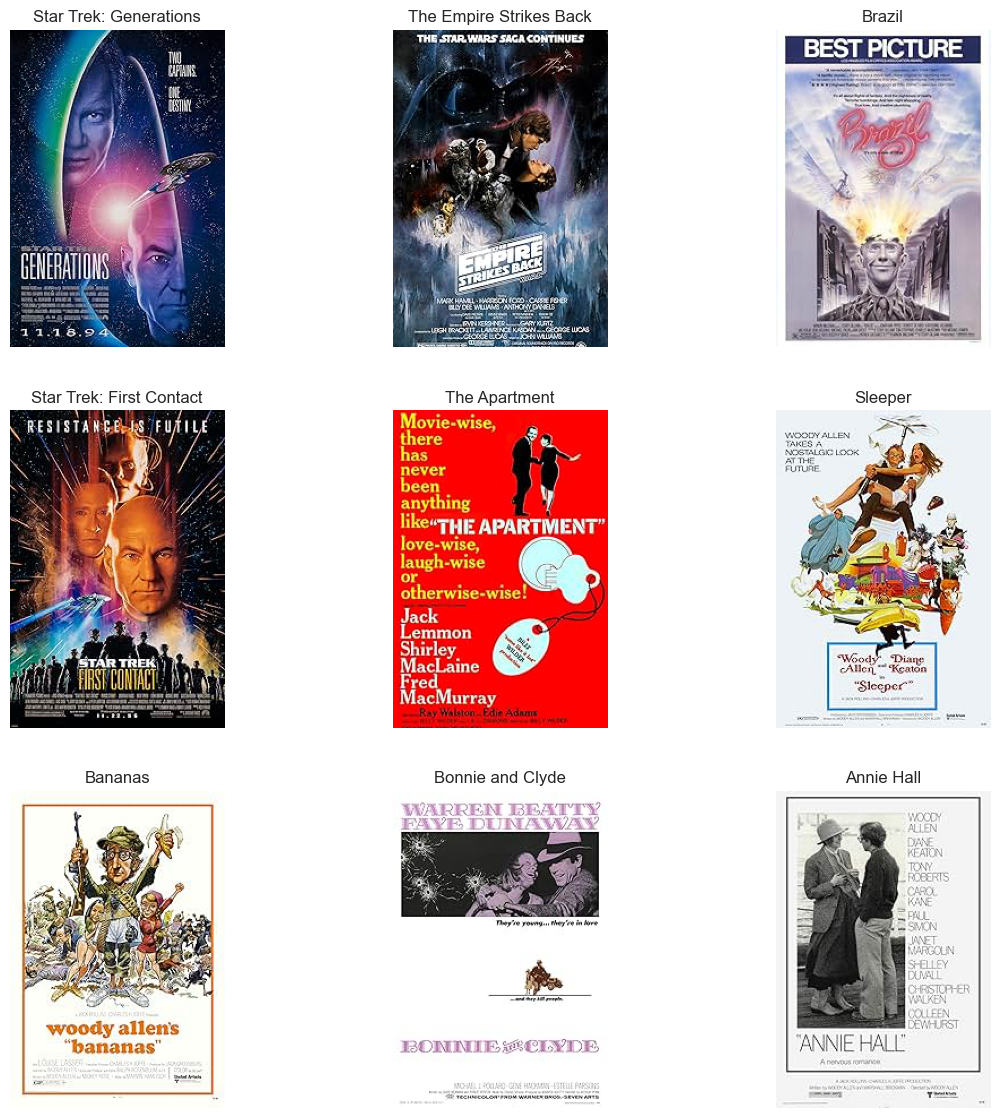

In [69]:
m_links = pd.read_csv('archive/links.csv')
m_meta = pd.read_csv('archive/movies_metadata.csv')

i = 1

plt.figure(figsize=(14, 14))
for m_tuple in ranked_movies:
    m_id = m_tuple[0]
    #get imdb id
    imdb_id = str(m_links[m_links['movieId'] == m_id]['imdbId'].values[0])
    # condition to match id
    zero_prefix = 0
    if len(imdb_id) < 7:
        zero_prefix = 7 - len(imdb_id)
    imdb_id = 'tt' + zero_prefix * '0' + imdb_id
    print("Imbd Id:", imdb_id)
    # get tmdb id
    tmdb_id = str(int(m_links[m_links['movieId'] == m_id]['tmdbId'].values[0]))
    print("Tmdb Id:", tmdb_id)

    suggested_movie = m_meta[m_meta['id'] == tmdb_id]['title'].values[0]
    print("Movie to suggest:", suggested_movie)

    plt.subplot(3, 3, i)
    
    # plot image
    plt.imshow(get_image(imdb_id))
    plt.axis('off')
    plt.title(suggested_movie)
    # only show 9 movies
    if i == 9:
        break
    i += 1
    
plt.show()
del(m_links)
del(m_meta)

In [29]:
del(m_links)
del(m_meta)

In [81]:
# # create a movie-movie matrix
# n, m = user_movie.shape

# # create numpy array
# sim_array = np.zeros((m, m))
# tik = time.time()

# for i, movie1 in enumerate(user_movie.columns):
#     # fix diagonal entries of same users
#     sim_array[i, i] = 1.0
#     # print progress
#     if i % 100 == 0:
#         print("Index:", i, "Time elapsed:", round(time.time() - tik, 2), "seconds")
#         tik = time.time()
#     for j, movie2 in enumerate(user_movie.columns[i+1:]):
#         # calculate similarity
#         similarity = user_cosine_similarity(user_movie[movie1], user_movie[movie2])
#         if not np.isnan(similarity):
#             # input similarity score
#             sim_array[i, j] = similarity
#             sim_array[j, i] = similarity

# movie_movie = pd.DataFrame(sim_array, index=user_movie.columns, columns=user_movie.columns)
# del(sim_array)

# movie_movie.head()

Index: 0 Time elapsed: 0.0 seconds
Index: 100 Time elapsed: 609.09 seconds



KeyboardInterrupt



In [10]:
from scipy.sparse import coo_matrix

In [11]:
### Map userId and movieId to integer indices
user_idx = {id_: idx for idx, id_ in enumerate(df['userId'].unique())}
movie_idx = {id_: idx for idx, id_ in enumerate(df['movieId'].unique())}
df['user_index'] = df['userId'].map(user_idx)
df['movie_index'] = df['movieId'].map(movie_idx)

# Build the COO sparse matrix
user_movie_scipy = coo_matrix(
    (df['rating'], (df['user_index'], df['movie_index'])),
    shape=(len(user_idx), len(movie_idx))
)

user_movie_scipy

<671x9066 sparse matrix of type '<class 'numpy.float64'>'
	with 100004 stored elements in COOrdinate format>

In [12]:
user_movie_scipy = user_movie_scipy.tocsr()
user_movie_scipy

<671x9066 sparse matrix of type '<class 'numpy.float64'>'
	with 100004 stored elements in Compressed Sparse Row format>

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
tik = time.time()

user_user = cosine_similarity(user_movie_scipy, dense_output=False)

print(user_user.shape)
print("Time taken:", str(time.time() - tik), 'seconds')

Time taken: 0.02400350570678711 seconds


In [15]:
np.squeeze(user_user[563].toarray())

array([0.08167271, 0.17362874, 0.11458203, 0.30462899, 0.10991806,
       0.07399233, 0.19386586, 0.13467631, 0.11622165, 0.13781439,
       0.04225411, 0.10425574, 0.07465636, 0.05236402, 0.32195562,
       0.04892452, 0.20808754, 0.12965154, 0.35823392, 0.12310309,
       0.2393945 , 0.19125783, 0.26229651, 0.09463632, 0.10146407,
       0.08387889, 0.09453891, 0.11865697, 0.04603698, 0.41794504,
       0.09675831, 0.12020417, 0.12906682, 0.25597526, 0.08164848,
       0.17021523, 0.07792665, 0.07266736, 0.14519182, 0.02844517,
       0.1896324 , 0.09340822, 0.18365167, 0.08284975, 0.06520189,
       0.05189897, 0.12289019, 0.0856968 , 0.14372872, 0.13438336,
       0.0796354 , 0.02713309, 0.1152099 , 0.02242268, 0.0912741 ,
       0.15776198, 0.28976852, 0.13283288, 0.12825317, 0.09344039,
       0.10851516, 0.028237  , 0.15138923, 0.09099166, 0.11572558,
       0.14666215, 0.15242409, 0.14736614, 0.13129282, 0.13693915,
       0.09597254, 0.0766406 , 0.28595195, 0.1294892 , 0.17175

In [102]:
def find_top_N_similar(user_id, mat, N=10):
    idx = user_idx[user_id]
    similarities = np.squeeze(mat[idx].toarray())
    sim_dict = {id_: sim for id_, sim in zip(user_idx.keys(), similarities)}
    return dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=True))

def find_candidate_movies(user_id, mat):
    # find top n similar users
    top_n = find_top_N_similar(user_id, mat, 10)
    # initialize candidate movies dictionary
    candidate_movies = {}
    rating_threshold = 1.2

    for item in top_n.items():
        user = item[0]
        sim = item[1]
    
        if user != user_id:
            
            idx = user_idx[user] # other user
            idx_current_user = user_idx[user_id] # current user
            
            unwatched = np.array((user_movie_scipy[idx].toarray()[0] != 0) & ~(user_movie_scipy[idx_current_user].toarray()[0] != 0)) # boolean array of unwatched movies
            indices = np.where(unwatched)[0] # indices of the movies
            unwatched = user_movie_scipy[idx].toarray()[0][unwatched] # movies watched by other users but not by current user
            # print(indices)
            # print(unwatched)
            # print("======="*20)
            
            candidate_movies[user] = [(df[df['movie_index'] == m]['movieId'].values[0], sim*r
                                      ) for m, r in zip(indices, unwatched) if np.round(r*sim, 1) >= rating_threshold]
            
    # Remove keys with empty lists from candidate_movies
    candidate_movies = {k: v for k, v in candidate_movies.items() if v}
    
    return candidate_movies


In [103]:
# (user_movie_scipy[564].toarray()[0] != 0)

In [104]:
from collections import defaultdict

def aggregate_candidate_movies(candidate_movies: dict):
    scores = defaultdict(list)
    for movie_list in candidate_movies.values():
        for movie_id, weighted_score in movie_list:
            scores[movie_id].append(weighted_score)
    # Option 1: Use average weighted score
    aggregated = {m: sum(wscores)/len(wscores) for m, wscores in scores.items()}
    return aggregated

def ranked_candidate_movies(aggregated_scores: dict):
    # Sort by score descending
    return sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    

In [115]:
candidate_movies = find_candidate_movies(135, user_user)
aggregated_scores = aggregate_candidate_movies(candidate_movies)
ranked_movies = ranked_candidate_movies(aggregated_scores)
ranked_movies

[(616, 1.436102057259364),
 (2, 1.436102057259364),
 (5, 1.436102057259364),
 (16, 1.436102057259364),
 (494, 1.436102057259364),
 (647, 1.436102057259364),
 (74, 1.436102057259364),
 (79, 1.436102057259364),
 (140, 1.436102057259364),
 (105, 1.436102057259364),
 (24, 1.436102057259364),
 (8, 1.436102057259364),
 (711, 1.436102057259364)]

C:\Users\Svk\AppData\Local\Temp\ipykernel_11884\2345724703.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  m_meta = pd.read_csv('archive/movies_metadata.csv')


Imbd Id: tt0065421
Tmdb Id: 10112
Movie to suggest: The Aristocats
Imbd Id: tt0113497
Tmdb Id: 8844
Movie to suggest: Jumanji
Imbd Id: tt0113041
Tmdb Id: 11862
Movie to suggest: Father of the Bride Part II
Imbd Id: tt0112641
Tmdb Id: 524
Movie to suggest: Casino
Imbd Id: tt0116253
Tmdb Id: 2320
Movie to suggest: Executive Decision
Imbd Id: tt0115956
Tmdb Id: 10684
Movie to suggest: Courage Under Fire
Imbd Id: tt0115644
Tmdb Id: 20927
Movie to suggest: Bed of Roses
Imbd Id: tt0116731
Tmdb Id: 9623
Movie to suggest: The Juror


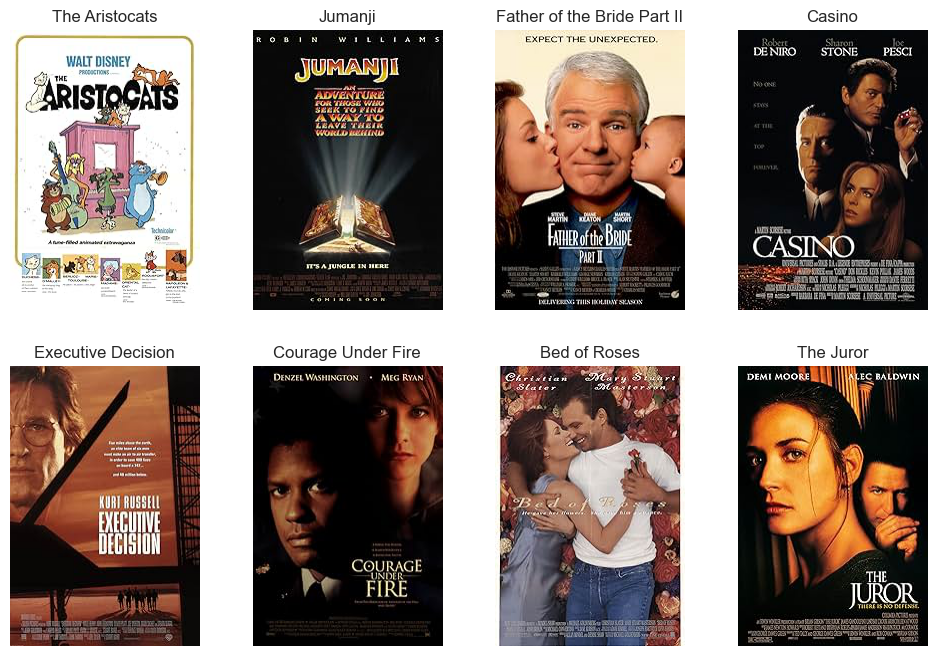

In [116]:
m_links = pd.read_csv('archive/links.csv')
m_meta = pd.read_csv('archive/movies_metadata.csv')

i = 1

plt.figure(figsize=(12, 8))
for m_tuple in ranked_movies:
    m_id = m_tuple[0]
    #get imdb id
    imdb_id = str(m_links[m_links['movieId'] == m_id]['imdbId'].values[0])
    # condition to match id
    zero_prefix = 0
    if len(imdb_id) < 7:
        zero_prefix = 7 - len(imdb_id)
    imdb_id = 'tt' + zero_prefix * '0' + imdb_id
    print("Imbd Id:", imdb_id)
    # get tmdb id
    tmdb_id = str(int(m_links[m_links['movieId'] == m_id]['tmdbId'].values[0]))
    print("Tmdb Id:", tmdb_id)

    suggested_movie = m_meta[m_meta['id'] == tmdb_id]['title'].values[0]
    print("Movie to suggest:", suggested_movie)

    plt.subplot(2, 4, i)
    
    # plot image
    plt.imshow(get_image(imdb_id))
    plt.axis('off')
    plt.title(suggested_movie)
    # only show 9 movies
    if i == 8:
        break
    i += 1
    
plt.show()
del(m_links)
del(m_meta)

In [117]:
tik = time.time()

movie_movie = cosine_similarity(user_movie_scipy.T, dense_output=False)

print(movie_movie.shape)
print("Time taken:", str(time.time() - tik), 'seconds')

(9066, 9066)
Time taken: 0.28801965713500977 seconds


In [138]:
def find_top_N_similar(movie_id, mat, N=10):
    idx = movie_idx[movie_id]
    similarities = np.squeeze(mat[idx].toarray())
    sim_dict = {id_: sim for id_, sim in zip(movie_idx.keys(), similarities)}
    return dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=True))

def find_candidate_movies(movie_id, mat):
    # find top n similar users
    top_n = find_top_N_similar(movie_id, mat, 10)
    # initialize candidate movies dictionary
    candidate_movies = {}
    rating_threshold = 2

    for item in top_n.items():
        movie = item[0]
        sim = item[1]
    
        if movie != movie_id:
            
            idx = movie_idx[movie] # other user
            idx_current_movie = movie_idx[movie_id] # current user
            
            unwatched = np.array((user_movie_scipy[:, idx].T.toarray()[0] != 0) & ~(user_movie_scipy[:, idx_current_movie].T.toarray()[0] != 0)) # boolean array of unwatched movies
            indices = np.where(unwatched)[0] # indices of the movies
            unwatched = user_movie_scipy[:, idx].T.toarray()[0][unwatched] # movies watched by other users but not by current user
            # print(indices)
            # print(unwatched)
            # print("======="*20)
            
            candidate_movies[movie] = [(df[df['movie_index'] == m]['movieId'].values[0], sim*r
                                      ) for m, r in zip(indices, unwatched) if np.round(r*sim, 1) >= rating_threshold]
            
    # Remove keys with empty lists from candidate_movies
    candidate_movies = {k: v for k, v in candidate_movies.items() if v}
    
    return candidate_movies

In [141]:
top_n = find_top_N_similar(222, movie_movie)
top_n

{222: 0.9999999999999997,
 1268: 0.5007928147107809,
 195: 0.45434703209174254,
 273: 0.44339541971480645,
 1629: 0.4404524772836256,
 237: 0.4261481427743774,
 230: 0.4223793662951976,
 57: 0.40094473532494523,
 17: 0.3967188993236806,
 453: 0.3936423781241488,
 691: 0.3911447505765127,
 270: 0.3895374788081979,
 1330: 0.3856162985740244,
 3103: 0.383966339668972,
 371: 0.3780395817834601,
 1187: 0.37652962868496676,
 236: 0.37535267312321524,
 1919: 0.3748975029753798,
 266: 0.37407392014259855,
 498: 0.37301830566314464,
 339: 0.37161147956468044,
 261: 0.3663668443611297,
 351: 0.3645148791242335,
 2119: 0.3645022790802181,
 2121: 0.3638679759598542,
 278: 0.36377976461037953,
 1353: 0.36190898223300705,
 2875: 0.36045657867230546,
 1995: 0.3597684832480075,
 1331: 0.3588167936951383,
 39: 0.3524776628655987,
 2263: 0.3499089371785693,
 381: 0.3485496674666614,
 1984: 0.3480800228772859,
 342: 0.34646690246700246,
 225: 0.3463302021957207,
 11: 0.33944643298097354,
 2751: 0.3393184

In [159]:



def find_top_N_similar_movies(user_id, threshold=3):

    idx = user_idx[user_id]
    user_ratings = user_movie_scipy[idx].toarray()[0] # movies user liked
    liked_indices = np.where(user_ratings > threshold)[0] # indices of the movies user liked
    
    recommended_scores = defaultdict(float)
    # loop through the liked movie indices
    for i in liked_indices:
        sim_scores = movie_movie[i].toarray()[0] # similarity scores for current movie
        # 
        for j, score in enumerate(sim_scores):
            # check if user hasnt watched this movie
            if user_ratings[j] == 0.0:
                recommended_scores[j] += score # summing sim scores for the same movie from all user-liked movie

    top_recs = sorted(recommended_scores.items(), key=lambda x: x[1], reverse=True)
    top_recs = [(df[df['movie_index'] == k]['movieId'].values[0], v) for k, v in top_recs]
    
    return top_recs

In [162]:
top_recs = find_top_N_similar_movies(135)
top_recs

[(633, 0.9289075512931049),
 (68, 0.9032491029998956),
 (3813, 0.8187026052229246),
 (608, 0.8130349352360258),
 (1089, 0.8004963818557481),
 (32, 0.7845479179079304),
 (324, 0.784490676190584),
 (461, 0.7720696647381025),
 (766, 0.7708405752467493),
 (1080, 0.7619816526356322),
 (223, 0.7566536451968808),
 (1279, 0.7560988802517987),
 (369, 0.7559094915580561),
 (2966, 0.7467098948225603),
 (296, 0.7422856790191189),
 (3728, 0.741414747760399),
 (1206, 0.7354743641297196),
 (1732, 0.7288684748079636),
 (535, 0.7268828241171915),
 (124, 0.717337677760758),
 (263, 0.717337677760758),
 (756, 0.717337677760758),
 (844, 0.717337677760758),
 (1516, 0.7134929771188308),
 (25, 0.7123435266569328),
 (2475, 0.7077759983241287),
 (1258, 0.7071164335766011),
 (85, 0.7014548205708728),
 (3304, 0.697523023854476),
 (728, 0.6956699745535952),
 (2606, 0.6945187020722443),
 (47, 0.6940989853294894),
 (3499, 0.6934095782711883),
 (3506, 0.6933529016113635),
 (538, 0.6932595732118563),
 (36, 0.692411627

C:\Users\Svk\AppData\Local\Temp\ipykernel_11884\3272909970.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  m_meta = pd.read_csv('archive/movies_metadata.csv')


Imbd Id: tt0112844
Tmdb Id: 47449
Movie to suggest: Denise Calls Up
Imbd Id: tt0113149
Tmdb Id: 4482
Movie to suggest: French Twist
Imbd Id: tt0077742
Tmdb Id: 15867
Movie to suggest: Interiors
Imbd Id: tt0116282
Tmdb Id: 275
Movie to suggest: Fargo
Imbd Id: tt0105236
Tmdb Id: 500
Movie to suggest: Reservoir Dogs
Imbd Id: tt0114746
Tmdb Id: 63
Movie to suggest: Twelve Monkeys
Imbd Id: tt0111309
Tmdb Id: 36614
Movie to suggest: The Sum of Us
Imbd Id: tt0109913
Tmdb Id: 18620
Movie to suggest: Go Fish


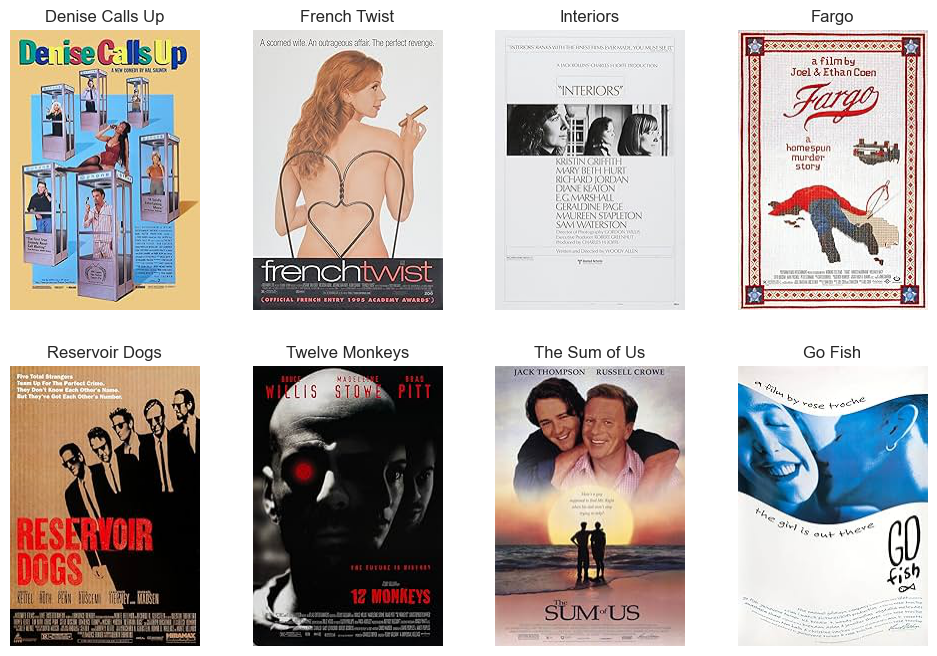

In [163]:
m_links = pd.read_csv('archive/links.csv')
m_meta = pd.read_csv('archive/movies_metadata.csv')

i = 1

plt.figure(figsize=(12, 8))
for m_tuple in top_recs:
    m_id = m_tuple[0]
    #get imdb id
    imdb_id = str(m_links[m_links['movieId'] == m_id]['imdbId'].values[0])
    # condition to match id
    zero_prefix = 0
    if len(imdb_id) < 7: # imdb_id consists of 0 prefixes
        zero_prefix = 7 - len(imdb_id)
    imdb_id = 'tt' + zero_prefix * '0' + imdb_id
    print("Imbd Id:", imdb_id)
    # get tmdb id
    tmdb_id = str(int(m_links[m_links['movieId'] == m_id]['tmdbId'].values[0]))
    print("Tmdb Id:", tmdb_id)

    suggested_movie = m_meta[m_meta['id'] == tmdb_id]['title'].values[0]
    print("Movie to suggest:", suggested_movie)

    plt.subplot(2, 4, i)
    
    # plot image
    plt.imshow(get_image(imdb_id))
    plt.axis('off')
    plt.title(suggested_movie)
    # only show 9 movies
    if i == 8:
        break
    i += 1
    
plt.show()
del(m_links)
del(m_meta)